# Posenet Tutorial

Tensorflow.js model `PoseNet` allows one to detect 2-dimensional human pose in real-time right in the browser. Check out their [github repo](https://github.com/jscriptcoder/tfjs-posenet) for details.

If you use it in your project and "record" a session of the detected keypoints, you will end up with an array of "frames" where each frame is a pose. This is what we will analyze in this tutorial. To make this self-contained, we are going to use a public dataset as described below.

In [2]:
data_url = (
    "https://raw.githubusercontent.com/maddyonline/posenet-frames/main/frames.json"
)


In [3]:
import requests
import json
data = json.loads(requests.get(data_url).text)

In [4]:
# data is essentially of the following shape
# {"frames": [{},{}, ..., {}]}

data.keys(), len(data['frames'])

(dict_keys(['frames']), 357)

In [5]:
# Here each array element represents a frame and contains keypoints of detected pose 
# together with score which represents the confidence of prediction

data['frames'][10]['score'], data['frames'][10]['keypoints'][:5]

(0.8093167030636002,
 [{'score': 0.9991793036460876,
   'part': 'nose',
   'position': {'x': 407.1552302141598, 'y': 120.41525644087142}},
  {'score': 0.9978790283203125,
   'part': 'leftEye',
   'position': {'x': 397.6652344581218, 'y': 109.77402030262039}},
  {'score': 0.995159924030304,
   'part': 'rightEye',
   'position': {'x': 419.6274877169717, 'y': 109.20874569666526}},
  {'score': 0.8933783173561096,
   'part': 'leftEar',
   'position': {'x': 380.91065450586694, 'y': 123.687608177096}},
  {'score': 0.7928388118743896,
   'part': 'rightEar',
   'position': {'x': 434.38514727284473, 'y': 117.7815080338415}}])

In [6]:
# there are a total of 17 keypoints

len(data['frames'][10]['keypoints'])

17

In [29]:
[kp['part'] for kp in data['frames'][10]['keypoints']]


['nose',
 'leftEye',
 'rightEye',
 'leftEar',
 'rightEar',
 'leftShoulder',
 'rightShoulder',
 'leftElbow',
 'rightElbow',
 'leftWrist',
 'rightWrist',
 'leftHip',
 'rightHip',
 'leftKnee',
 'rightKnee',
 'leftAnkle',
 'rightAnkle']

In [30]:
# let us focus on a specific frame namely the 10th frame




# let us assemble (confidence) score for each of the 17 parts that is detectec
# We use the variable 'kps' to refer to keypoints-scores

kps = kps = [kp['score'] for kp in data['frames'][10]['keypoints']]
len(kps), kps

(17,
 [0.9991793036460876,
  0.9978790283203125,
  0.995159924030304,
  0.8933783173561096,
  0.7928388118743896,
  0.995917022228241,
  0.9966772794723511,
  0.9944100975990295,
  0.9921382069587708,
  0.9832354784011841,
  0.9663960933685303,
  0.9475935697555542,
  0.9950150847434998,
  0.5011693835258484,
  0.5367682576179504,
  0.09801270812749863,
  0.07261538505554199])

In [51]:
import numpy as np

# Let us create a list of these keypoints and which part connects to which
# Taken from github.com//...
PART_NAMES = [
    "nose", "leftEye", "rightEye", "leftEar", "rightEar", "leftShoulder",
    "rightShoulder", "leftElbow", "rightElbow", "leftWrist", "rightWrist",
    "leftHip", "rightHip", "leftKnee", "rightKnee", "leftAnkle", "rightAnkle"
]

NUM_KEYPOINTS = len(PART_NAMES)

PART_IDS = {pn: pid for pid, pn in enumerate(PART_NAMES)}

CONNECTED_PART_NAMES = [
    ("leftHip", "leftShoulder"), ("leftElbow", "leftShoulder"),
    ("leftElbow", "leftWrist"), ("leftHip", "leftKnee"),
    ("leftKnee", "leftAnkle"), ("rightHip", "rightShoulder"),
    ("rightElbow", "rightShoulder"), ("rightElbow", "rightWrist"),
    ("rightHip", "rightKnee"), ("rightKnee", "rightAnkle"),
    ("leftShoulder", "rightShoulder"), ("leftHip", "rightHip")
]
CONNECTED_PART_INDICES = np.array([(PART_IDS[a], PART_IDS[b]) for a, b in CONNECTED_PART_NAMES])

# CONNECTED_PART_INDICES gives the indices of which keypoint to connect to which keypoint
# So for exmpale, (11, 5) means that 11th keypoint is adjacent to 5th keypoint.

# We see that there are potentially 12 adjacent keypoints or "edges" in our representation#

CONNECTED_PART_INDICES, CONNECTED_PART_INDICES.shape

(array([[11,  5],
        [ 7,  5],
        [ 7,  9],
        [11, 13],
        [13, 15],
        [12,  6],
        [ 8,  6],
        [ 8, 10],
        [12, 14],
        [14, 16],
        [ 5,  6],
        [11, 12]]),
 (12, 2))

In [32]:
# Out of these 12, we only keep those edges for which we have high confidence.
# For every edge such as ("leftHip", "leftShoulder") we want to connect them
# if and only if both score("leftHip") and score("leftShoulder") are high.

In [37]:
scores_on_adjacent_points = np.vstack([
    np.take(kps, np.array(CONNECTED_PART_INDICES)[:, 0]), 
    np.take(kps, np.array(CONNECTED_PART_INDICES)[:, 1])
    ]).T

In [41]:
# this variable replaces CONNECTED_PART_INDICES pairs with the scores
# So for example, (11, 5) => [score(11-th keypoint), score(5-th keypoint)]
scores_on_adjacent_points, scores_on_adjacent_points.shape

(array([[0.94759357, 0.99591702],
        [0.9944101 , 0.99591702],
        [0.9944101 , 0.98323548],
        [0.94759357, 0.50116938],
        [0.50116938, 0.09801271],
        [0.99501508, 0.99667728],
        [0.99213821, 0.99667728],
        [0.99213821, 0.96639609],
        [0.99501508, 0.53676826],
        [0.53676826, 0.07261539],
        [0.99591702, 0.99667728],
        [0.94759357, 0.99501508]]),
 (12, 2))

In [48]:
# Recall we want to only keep rows in `scores_on_adjacent_points` where both entries are high
# That is minimum of the two entries is above a threshold (say 0.5)

np.min(scores_on_adjacent_points, axis=1)

array([0.94759357, 0.9944101 , 0.98323548, 0.50116938, 0.09801271,
       0.99501508, 0.99213821, 0.96639609, 0.53676826, 0.07261539,
       0.99591702, 0.94759357])

In [50]:
np.min(scores_on_adjacent_points, axis=1) > 0.5

array([ True,  True,  True,  True, False,  True,  True,  True,  True,
       False,  True,  True])

In [56]:
# selecting relevant indices (we see only 10 out of 12 rows remain)

relevant = np.min(scores_on_adjacent_points, axis=1) > 0.5
high_confidence_visible_adjacent_parts = CONNECTED_PART_INDICES[relevant]
high_confidence_visible_adjacent_parts, high_confidence_visible_adjacent_parts.shape

(array([[11,  5],
        [ 7,  5],
        [ 7,  9],
        [11, 13],
        [12,  6],
        [ 8,  6],
        [ 8, 10],
        [12, 14],
        [ 5,  6],
        [11, 12]]),
 (10, 2))

In [57]:
# Now our goal is to replace each of these keypoint indices with their actual x,y coordinates
# That is, we want to replace [11, 5] => with [[x1,y1], [x2, y2]]  
# where (x1, y1) are coordinaes for joint-11 and (x2, y2) are coordinates for joint-5
# Let us call [x1, y1] as "start" and [x2, y2] as "end" representing start and end of a line-segment

In [62]:
# These are the joint/keypoint indices for "start" points
high_confidence_visible_adjacent_parts[:, 0]

array([11,  7,  7, 11, 12,  8,  8, 12,  5, 11])

In [63]:
# These are the joint/keypoint indices for "end" points
high_confidence_visible_adjacent_parts[:, 1]

array([ 5,  5,  9, 13,  6,  6, 10, 14,  6, 12])

In [69]:
# Before this let us get all frames keypoints in an array
def get_landmark_coordinates(keypoints):
    return np.array([[landmark['position']['x'], landmark['position']['y']] for landmark in keypoints])

frames_arr = np.array([get_landmark_coordinates(frame['keypoints']) for frame in data['frames']])

In [71]:
# this represents the 17 keypoints x-y coordinates for all 357 frames
frames_arr.shape

(357, 17, 2)

In [74]:
# Coming back to start/end array described above

start = np.take(frames_arr[10], high_confidence_visible_adjacent_parts[:, 0], axis=0)

start, start.shape


(array([[377.38682063, 377.64601533],
        [294.07215448, 249.62049551],
        [294.07215448, 249.62049551],
        [377.38682063, 377.64601533],
        [459.39856076, 375.88835839],
        [516.10919718, 284.24739437],
        [516.10919718, 284.24739437],
        [459.39856076, 375.88835839],
        [349.77654056, 194.69656503],
        [377.38682063, 377.64601533]]),
 (10, 2))

In [75]:
end = np.take(frames_arr[10], high_confidence_visible_adjacent_parts[:, 1], axis=0)

end, end.shape

(array([[349.77654056, 194.69656503],
        [349.77654056, 194.69656503],
        [314.73922124, 302.51949325],
        [400.35234695, 530.79847046],
        [465.91592918, 192.37962003],
        [465.91592918, 192.37962003],
        [491.12625585, 301.87612452],
        [477.52848988, 532.84218517],
        [465.91592918, 192.37962003],
        [459.39856076, 375.88835839]]),
 (10, 2))

In [76]:
# Line segments that we need to join

segments = np.hstack([start, end]).reshape((10, 2, 2))
segments, segments.shape

(array([[[377.38682063, 377.64601533],
         [349.77654056, 194.69656503]],
 
        [[294.07215448, 249.62049551],
         [349.77654056, 194.69656503]],
 
        [[294.07215448, 249.62049551],
         [314.73922124, 302.51949325]],
 
        [[377.38682063, 377.64601533],
         [400.35234695, 530.79847046]],
 
        [[459.39856076, 375.88835839],
         [465.91592918, 192.37962003]],
 
        [[516.10919718, 284.24739437],
         [465.91592918, 192.37962003]],
 
        [[516.10919718, 284.24739437],
         [491.12625585, 301.87612452]],
 
        [[459.39856076, 375.88835839],
         [477.52848988, 532.84218517]],
 
        [[349.77654056, 194.69656503],
         [465.91592918, 192.37962003]],
 
        [[377.38682063, 377.64601533],
         [459.39856076, 375.88835839]]]),
 (10, 2, 2))

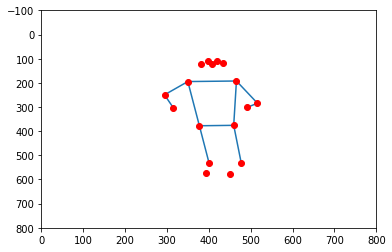

In [78]:
from matplotlib.lines import Line2D
from matplotlib.collections import LineCollection
import matplotlib.pyplot as plt

collection = LineCollection(segments)

fig, ax = plt.subplots()
ax.add_collection(collection)
ax.plot(frames_arr[10][:, 0], frames_arr[10][:, 1], 'ro')
ax.set_xlim(0, 800)
ax.set_ylim(-100, 800)
plt.gca().invert_yaxis()
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7de08bbf-2a1e-4d1b-b678-13b0eb1146b3' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>